In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from prophet import Prophet
from tqdm import tqdm
import os
# =============================================
# 1. НАСТРОЙКА ВИЗУАЛИЗАЦИИ
# =============================================
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid", palette="husl", font_scale=1.1)
plt.rcParams.update({
    'figure.figsize': (14, 7),
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14
})

# =============================================
# 2. ФУНКЦИЯ ДЛЯ АНАЛИЗА ПРОПУСКОВ
# =============================================
def analyze_missing_data(df, source_name=""):
    """Анализ и визуализация пропущенных данных"""
    # Расчет статистики пропусков
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100
    
    # Создание DataFrame с результатами
    missing_df = pd.DataFrame({
        'Количество пропусков': missing_counts,
        'Процент пропусков': missing_percent.round(2)
    }).sort_values('Процент пропусков', ascending=False)
    
    # Фильтрация только столбцов с пропусками
    missing_df = missing_df[missing_df['Количество пропусков'] > 0]
    
    print(f"\nАнализ пропусков {source_name}:")
    print(f"Всего строк: {len(df)}")
    print(f"Столбцов с пропусками: {len(missing_df)}")
    
    if len(missing_df) > 0:
        display(missing_df)
        
        # Визуализация
        plt.figure(figsize=(14, 6))
        sns.barplot(
            x=missing_df['Процент пропусков'],
            y=missing_df.index,
            orient='h',
            palette='viridis'
        )
        plt.title(f'Распределение пропусков ({source_name})')
        plt.xlabel('Процент пропусков (%)')
        plt.ylabel('Атрибуты')
        plt.xlim(0, 100)
        plt.grid(axis='x')

        for i, (val, name) in enumerate(zip(missing_df['Процент пропусков'], missing_df.index)):
            plt.text(val + 1, i, f'{val}%', va='center')

        plt.tight_layout()
        plt.show()
        
        # Матрица пропусков
        msno.matrix(df)
        plt.title(f'Матрица пропусков ({source_name})')
        plt.show()
    else:
        print("Пропуски отсутствуют")
    
    return missing_df

# =============================================
# 3. ФУНКЦИЯ ДЛЯ ОБРАБОТКИ ПРОПУСКОВ
# =============================================
def handle_missing_data(df):
    """Обработка пропущенных значений в данных"""
    initial_rows = len(df)
    
    # 1. Обработка критических полей (даты)
    df['Issue Date'] = pd.to_datetime(df['Issue Date'], errors='coerce')
    df = df.dropna(subset=['Issue Date'])
    
    # 2. Обработка категориальных признаков
    cat_cols = ['Violation Code', 'Vehicle Make', 'Plate Type']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].fillna('UNKNOWN')
    
    # 3. Обработка числовых признаков (если есть)
    num_cols = df.select_dtypes(include=np.number).columns
    for col in num_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    
    print(f"\nОбработано пропусков:")
    print(f"- Удалено строк с пропущенными датами: {initial_rows - len(df)}")
    print(f"- Заполнено категориальных пропусков: {sum([col in df.columns for col in cat_cols])} столбцов")
    
    return df


1. Загрузка данных...


Обработка файлов:   0%|          | 0/4 [00:00<?, ?it/s]


Анализ пропусков ДО обработки (Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv):
Всего строк: 9100278
Столбцов с пропусками: 1


,Количество пропусков,Процент пропусков
Vehicle Make,63273,0.7


C:\Users\kotlo\AppData\Local\Temp\ipykernel_17640\3138616968.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


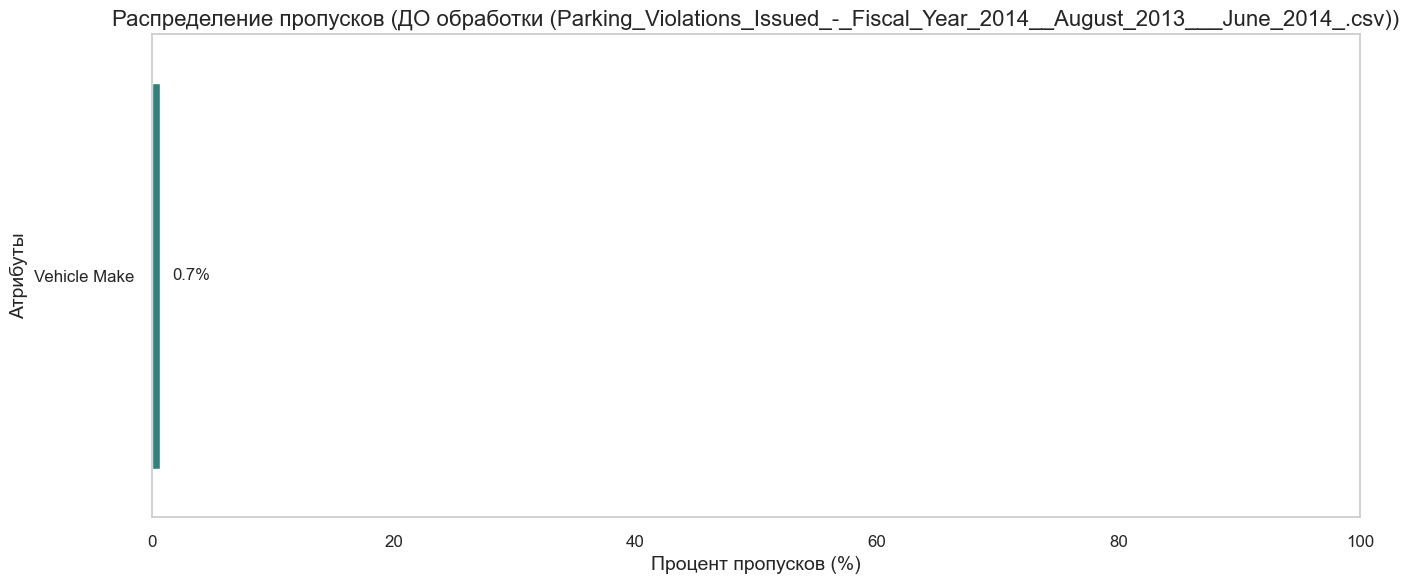

Обработка файлов:  25%|██▌       | 1/4 [00:14<00:43, 14.46s/it]


Ошибка при обработке Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv: name 'msno' is not defined

Анализ пропусков ДО обработки (Parking_Violations_Issued_-_Fiscal_Year_2015.csv):
Всего строк: 11809233
Столбцов с пропусками: 1


,Количество пропусков,Процент пропусков
Vehicle Make,75520,0.64


C:\Users\kotlo\AppData\Local\Temp\ipykernel_17640\3138616968.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


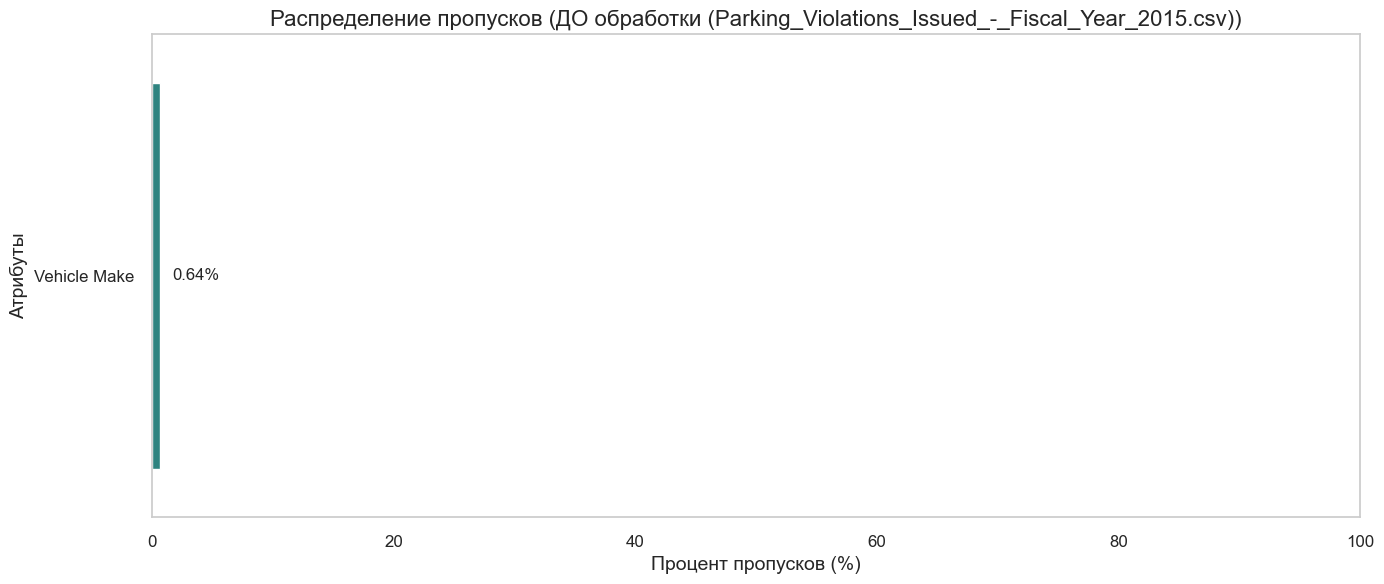

Обработка файлов:  50%|█████     | 2/4 [00:33<00:34, 17.39s/it]


Ошибка при обработке Parking_Violations_Issued_-_Fiscal_Year_2015.csv: name 'msno' is not defined

Анализ пропусков ДО обработки (Parking_Violations_Issued_-_Fiscal_Year_2016.csv):
Всего строк: 10626899
Столбцов с пропусками: 1


,Количество пропусков,Процент пропусков
Vehicle Make,63586,0.6


C:\Users\kotlo\AppData\Local\Temp\ipykernel_17640\3138616968.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


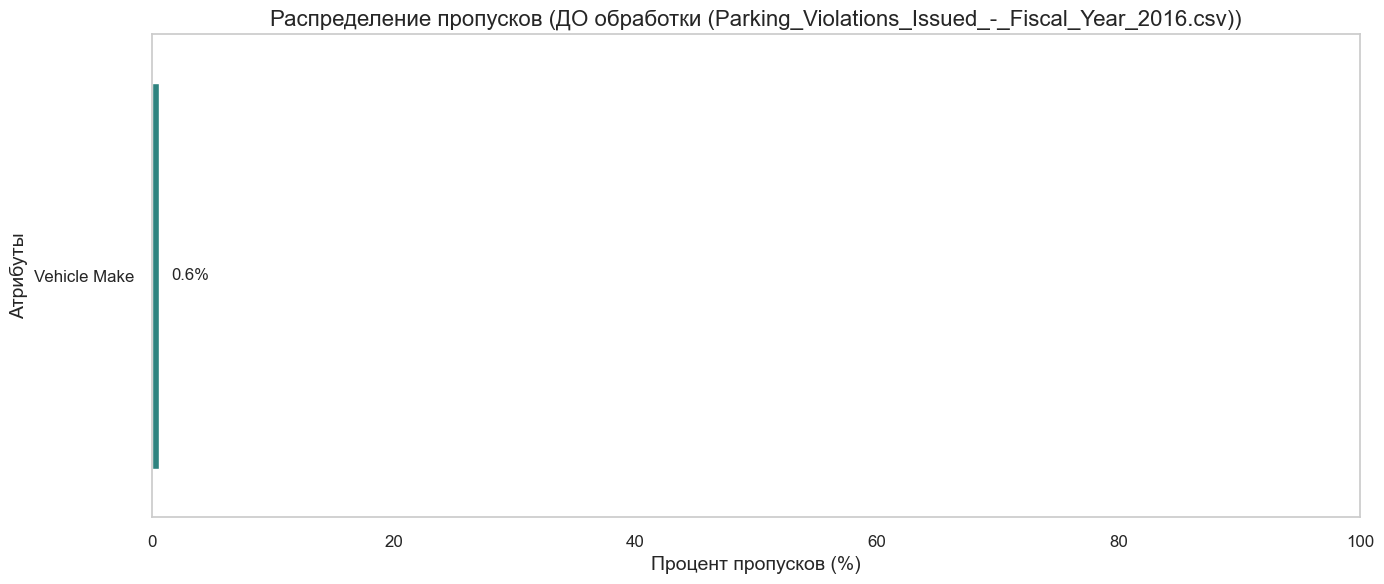

Обработка файлов:  75%|███████▌  | 3/4 [00:51<00:17, 17.42s/it]


Ошибка при обработке Parking_Violations_Issued_-_Fiscal_Year_2016.csv: name 'msno' is not defined

Анализ пропусков ДО обработки (Parking_Violations_Issued_-_Fiscal_Year_2017.csv):
Всего строк: 10803028
Столбцов с пропусками: 1


,Количество пропусков,Процент пропусков
Vehicle Make,73050,0.68


C:\Users\kotlo\AppData\Local\Temp\ipykernel_17640\3138616968.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


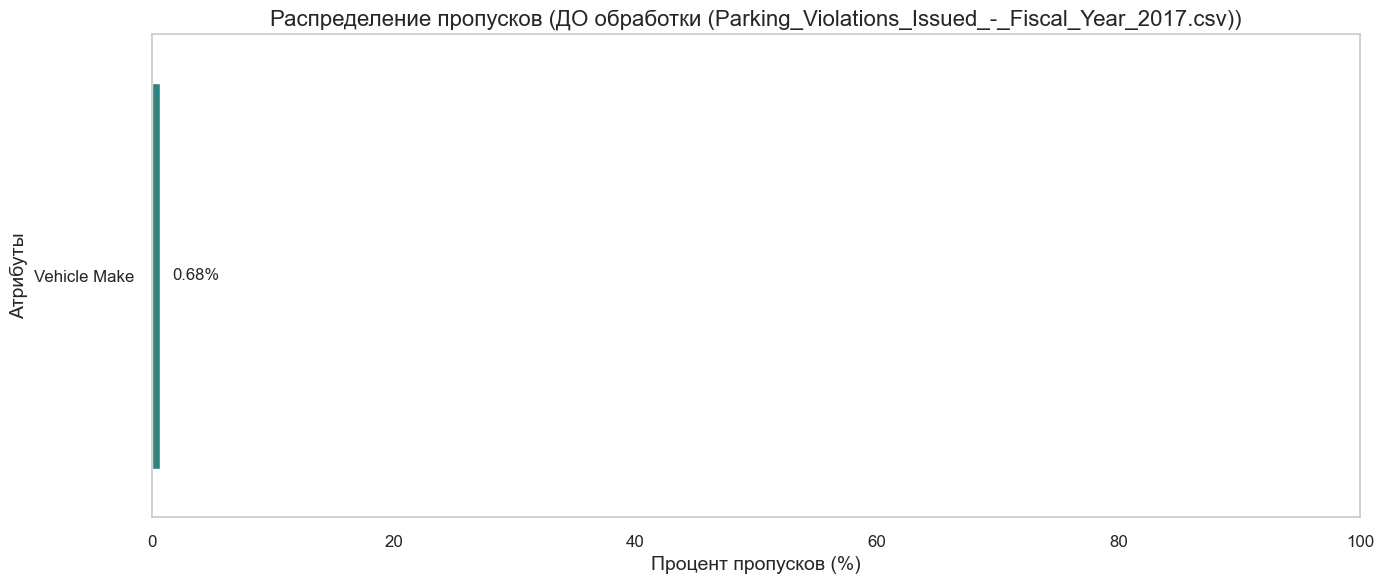

Обработка файлов: 100%|██████████| 4/4 [01:07<00:00, 16.98s/it]


Ошибка при обработке Parking_Violations_Issued_-_Fiscal_Year_2017.csv: name 'msno' is not defined


ValueError: Не удалось загрузить ни один файл

In [31]:
print("1. Загрузка данных...")

files = [
    'Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv',
    'Parking_Violations_Issued_-_Fiscal_Year_2015.csv',
    'Parking_Violations_Issued_-_Fiscal_Year_2016.csv',
    'Parking_Violations_Issued_-_Fiscal_Year_2017.csv'
]

all_data = []
for file in tqdm(files, desc="Обработка файлов"):
    try:
        if not os.path.exists(file):
            print(f"\nФайл {file} не найден, пропускаем")
            continue
            
        # Загрузка данных
        df = pd.read_csv(file, usecols=['Issue Date', 'Violation Code', 'Vehicle Make', 'Plate Type'])
        
        # Анализ пропусков (до обработки)
        _ = analyze_missing_data(df, f"ДО обработки ({os.path.basename(file)})")
        
        # Обработка пропусков
        df = handle_missing_data(df)
        
        # Анализ пропусков (после обработки)
        _ = analyze_missing_data(df, f"ПОСЛЕ обработки ({os.path.basename(file)})")
        
        if not df.empty:
            all_data.append(df)
            
    except Exception as e:
        print(f"\nОшибка при обработке {file}: {str(e)}")

if not all_data:
    raise ValueError("Не удалось загрузить ни один файл")

raw_data = pd.concat(all_data, ignore_index=True)
print(f"\nИтоговый набор данных: {len(raw_data)} строк")

In [9]:
# Объединение всех данных
raw_data = pd.concat(all_data, ignore_index=True)
print(f"\nУспешно загружено {len(raw_data)} записей")


Успешно загружено 42339438 записей


In [11]:
# =============================================
# 3. ПОДГОТОВКА ДАННЫХ
# =============================================
print("\nПодготовка данных...")

# Агрегация по дням
daily_counts = raw_data.resample('D', on='Issue Date').size().reset_index(name='count')

# Извлечение признаков
daily_counts['month'] = daily_counts['Issue Date'].dt.month
daily_counts['day_of_week'] = daily_counts['Issue Date'].dt.dayofweek  # 0-6 (пн-вс)
daily_counts['year'] = daily_counts['Issue Date'].dt.year

print(f"Подготовлено {len(daily_counts)} дней данных")



Подготовка данных...
Подготовлено 36415 дней данных



Визуализация сезонных паттернов...


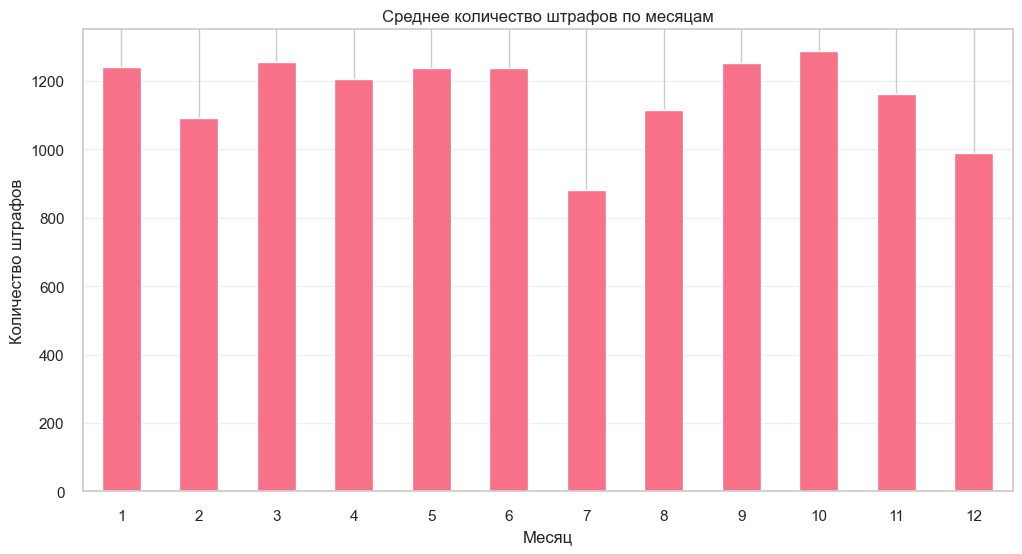

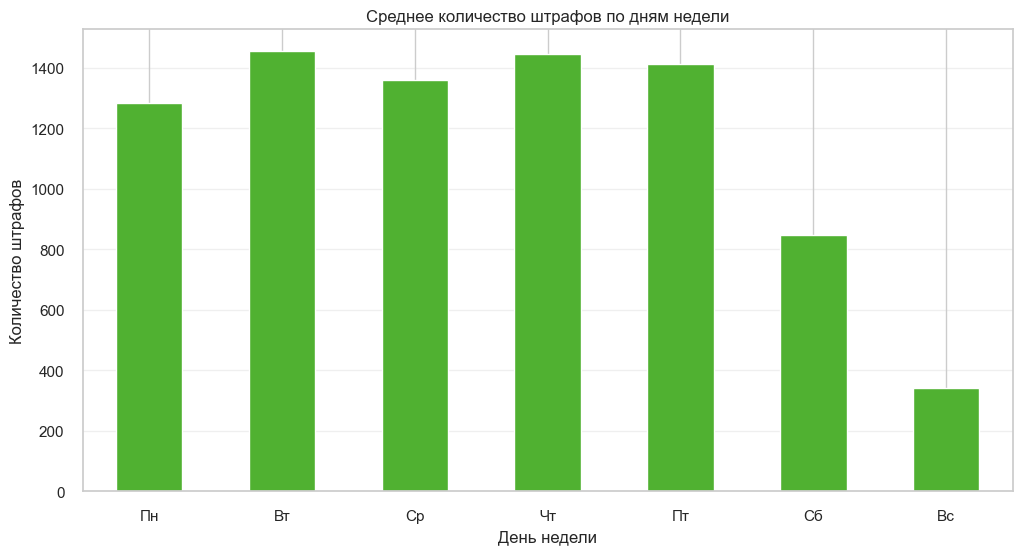

In [13]:
# =============================================
# 4. ВИЗУАЛИЗАЦИЯ СЕЗОННОСТИ
# =============================================
print("\nВизуализация сезонных паттернов...")

# По месяцам
monthly_avg = daily_counts.groupby('month')['count'].mean()
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar', color=sns.color_palette("husl")[0])
plt.title('Среднее количество штрафов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество штрафов')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

# По дням недели
weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
daily_avg = daily_counts.groupby('day_of_week')['count'].mean()
plt.figure(figsize=(12, 6))
daily_avg.plot(kind='bar', color=sns.color_palette("husl")[2])
plt.title('Среднее количество штрафов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество штрафов')
plt.xticks(range(7), weekday_names, rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()


Анализ с XGBoost...

Оценка модели XGBoost:
MAE: 1453.22
RMSE: 1539.85
R²: -183789968.00


<Figure size 1000x500 with 0 Axes>

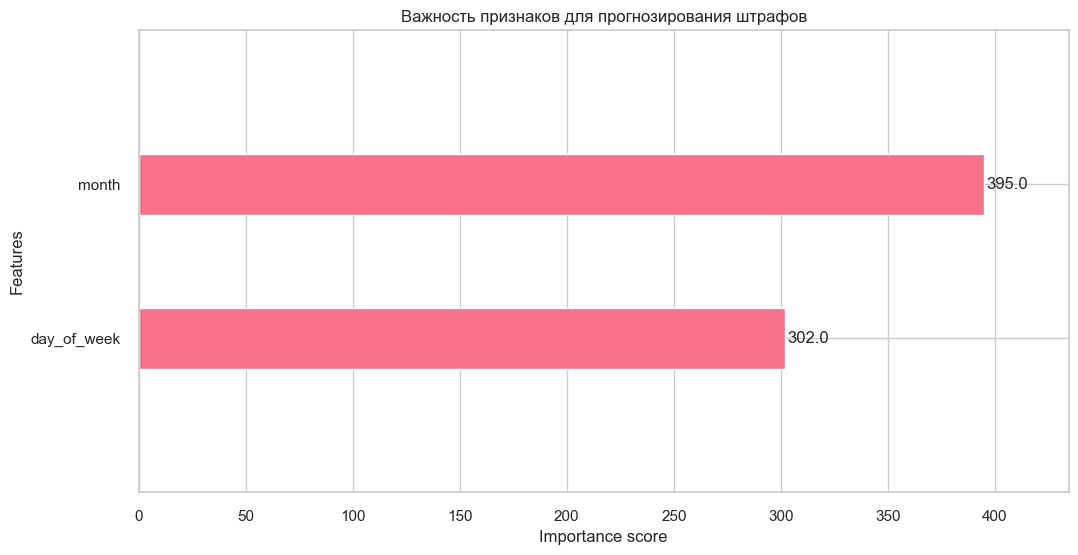

In [15]:
# =============================================
# 5. АНАЛИЗ С XGBOOST
# =============================================
print("\nАнализ с XGBoost...")

# Подготовка данных
X = daily_counts[['month', 'day_of_week']]
y = daily_counts['count']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False)

# Обучение модели
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Прогнозирование и оценка
y_pred = xgb_model.predict(X_test)

print("\nОценка модели XGBoost:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

# Визуализация важности признаков
plt.figure(figsize=(10, 5))
xgb.plot_importance(xgb_model, height=0.4)
plt.title('Важность признаков для прогнозирования штрафов')
plt.show()


Анализ с Prophet...


23:35:51 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing


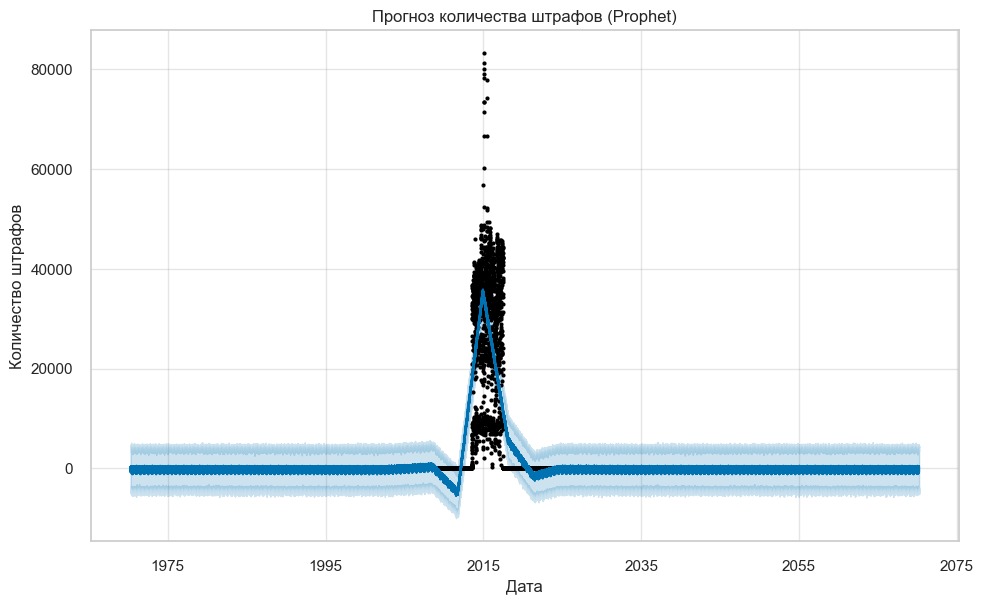

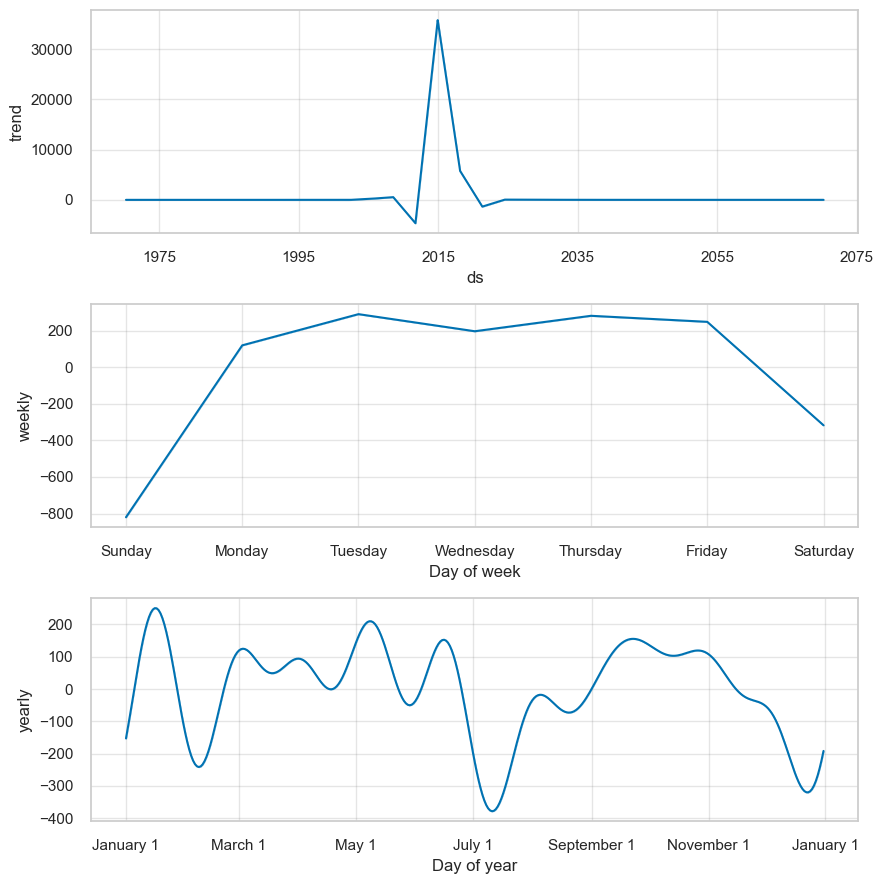


Анализ завершен успешно!


In [17]:
# =============================================
# 6. АНАЛИЗ С PROPHET
# =============================================
print("\nАнализ с Prophet...")

# Подготовка данных
prophet_df = daily_counts.rename(columns={'Issue Date': 'ds', 'count': 'y'})[['ds', 'y']]

# Создание и обучение модели
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
prophet_model.fit(prophet_df)

# Прогнозирование
future = prophet_model.make_future_dataframe(periods=90)  # +3 месяца
forecast = prophet_model.predict(future)

# Визуализация
fig1 = prophet_model.plot(forecast)
plt.title('Прогноз количества штрафов (Prophet)')
plt.xlabel('Дата')
plt.ylabel('Количество штрафов')
plt.show()

fig2 = prophet_model.plot_components(forecast)
plt.show()

print("\nАнализ завершен успешно!")